In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import Caltech256, Caltech101, CIFAR100
from torchvision import transforms
from torch.utils.data import DataLoader
import random

from library.taxonomy import Taxonomy
from library.models import UniversalResNetModel
from library.datasets import (
    Caltech256DataModule,
    Caltech101DataModule,
    CIFAR100ScaledDataModule,
    CombinedDataModule,
)

# Set random seeds for reproducibility
torch.manual_seed(44)
np.random.seed(44)
random.seed(44)

print("Loading three-domain taxonomy and model...")

# Load the three-domain taxonomy
three_domain_taxonomy = Taxonomy.load("taxonomies/three_domain_hypothesis.pkl")

# Load the trained three-domain model
model = UniversalResNetModel.load_from_checkpoint(
    "checkpoints/universal-resnet50-three-domain-hypothesis-min-val-loss.ckpt",
    taxonomy=three_domain_taxonomy,
)

# Set model to evaluation mode
model.eval()

print("Model loaded successfully!")

Loading three-domain taxonomy and model...
Model loaded successfully!
Model loaded successfully!


In [14]:
# Load datasets for sampling test images
print("Loading datasets...")

# Define transforms for visualization (without normalization for display)
display_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

# Define transforms for model inference (with normalization)
inference_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Load test datasets
caltech101_test = Caltech101(
    root="datasets/caltech101",
    target_type="category",
    transform=display_transform,
    download=False,
)

caltech256_test = Caltech256(
    root="datasets/caltech256", transform=display_transform, download=False
)

cifar100_test = CIFAR100(
    root="datasets/cifar100", train=False, transform=display_transform, download=False
)

print(f"Caltech-101 test samples: {len(caltech101_test)}")
print(f"Caltech-256 test samples: {len(caltech256_test)}")
print(f"CIFAR-100 test samples: {len(cifar100_test)}")

# Get label information
caltech101_labels = caltech101_test.categories
caltech256_labels = caltech256_test.categories
cifar100_labels = cifar100_test.classes

print(f"Caltech-101 classes: {len(caltech101_labels)}")
print(f"Caltech-256 classes: {len(caltech256_labels)}")
print(f"CIFAR-100 classes: {len(cifar100_labels)}")

Loading datasets...
Caltech-101 test samples: 8677
Caltech-256 test samples: 30607
CIFAR-100 test samples: 10000
Caltech-101 classes: 101
Caltech-256 classes: 257
CIFAR-100 classes: 100
Caltech-101 test samples: 8677
Caltech-256 test samples: 30607
CIFAR-100 test samples: 10000
Caltech-101 classes: 101
Caltech-256 classes: 257
CIFAR-100 classes: 100


In [15]:
# Sample 3 images from each domain
print("Sampling test images...")

# Sample from Caltech-101 (Domain 0)
caltech101_indices = random.sample(range(len(caltech101_test)), 3)
caltech101_samples = []
for idx in caltech101_indices:
    image, label = caltech101_test[idx]
    caltech101_samples.append(
        (image, label, caltech101_labels[label], 0)
    )  # domain_id = 0

# Sample from Caltech-256 (Domain 1)
caltech256_indices = random.sample(range(len(caltech256_test)), 3)
caltech256_samples = []
for idx in caltech256_indices:
    image, label = caltech256_test[idx]
    caltech256_samples.append(
        (image, label, caltech256_labels[label], 1)
    )  # domain_id = 1

# Sample from CIFAR-100 (Domain 2)
cifar100_indices = random.sample(range(len(cifar100_test)), 3)
cifar100_samples = []
for idx in cifar100_indices:
    image, label = cifar100_test[idx]
    cifar100_samples.append((image, label, cifar100_labels[label], 2))  # domain_id = 2

# Combine all samples
all_samples = caltech101_samples + caltech256_samples + cifar100_samples

# Print sample information
print("\nSampled images:")
for i, (image, label, label_name, domain_id) in enumerate(all_samples):
    domain_names = ["Caltech-101", "Caltech-256", "CIFAR-100"]
    print(f"{i+1}. {domain_names[domain_id]}: {label_name} (label: {label})")

Sampling test images...

Sampled images:
1. Caltech-101: okapi (label: 68)
2. Caltech-101: wild_cat (label: 97)
3. Caltech-101: accordion (label: 4)
4. Caltech-256: 051.cowboy-hat (label: 50)
5. Caltech-256: 113.hummingbird (label: 112)
6. Caltech-256: 067.eyeglasses (label: 66)
7. CIFAR-100: skyscraper (label: 76)
8. CIFAR-100: bicycle (label: 8)
9. CIFAR-100: telephone (label: 86)


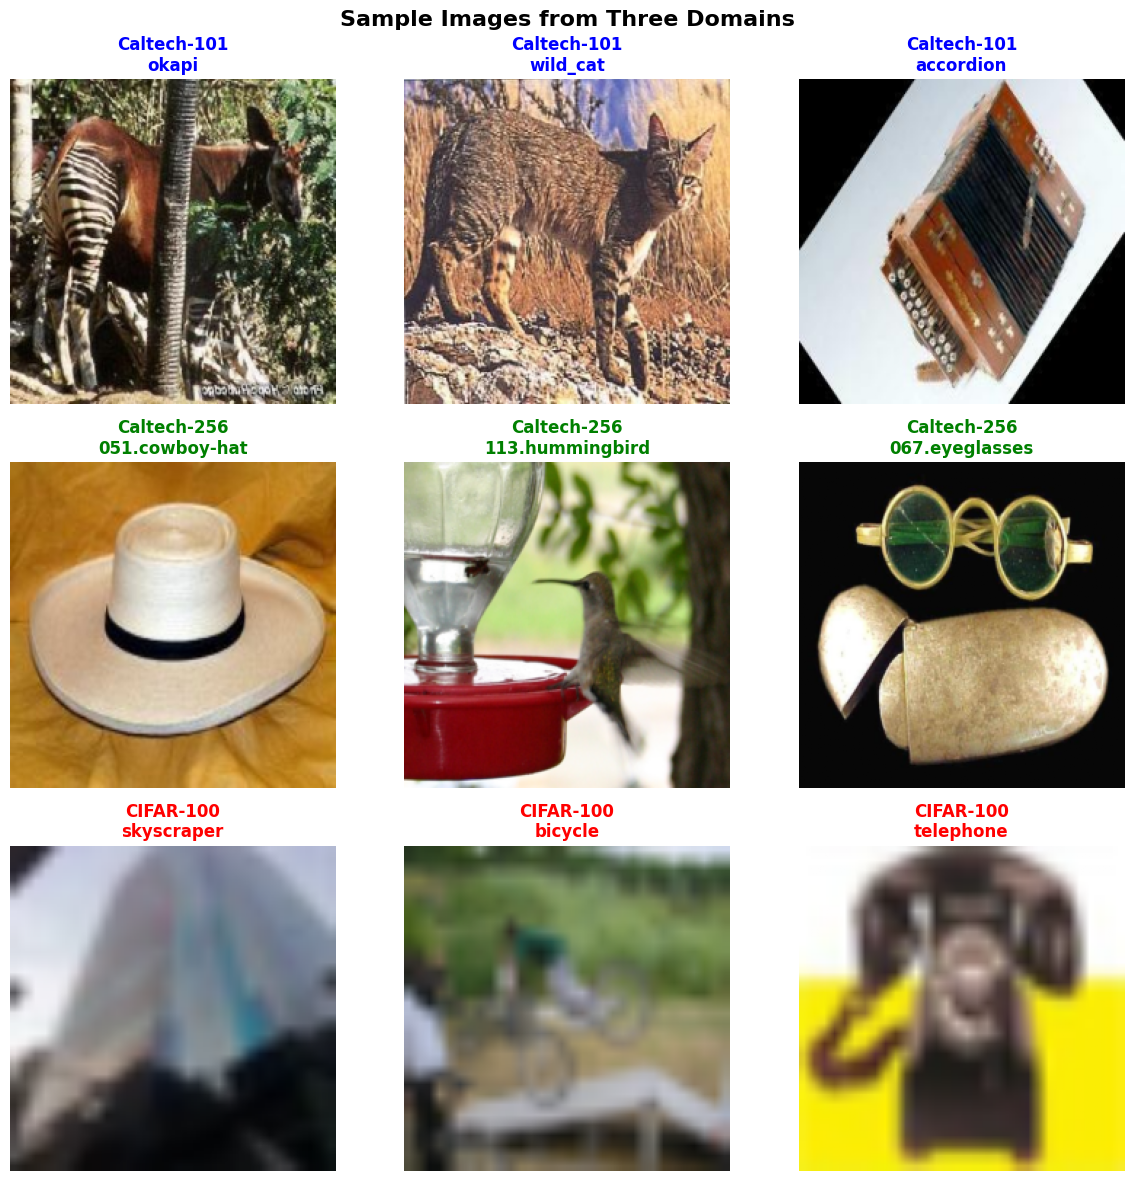

Images displayed successfully!


In [16]:
# Display the 9 sampled images in a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle("Sample Images from Three Domains", fontsize=16, fontweight="bold")

domain_names = ["Caltech-101", "Caltech-256", "CIFAR-100"]
domain_colors = ["blue", "green", "red"]

for i, (image, label, label_name, domain_id) in enumerate(all_samples):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    # Convert tensor to numpy and transpose for matplotlib
    img_np = image.permute(1, 2, 0).numpy()

    # Display image
    ax.imshow(img_np)
    ax.set_title(
        f"{domain_names[domain_id]}\n{label_name}",
        color=domain_colors[domain_id],
        fontweight="bold",
    )
    ax.axis("off")

plt.tight_layout()
plt.show()

print("Images displayed successfully!")

In [17]:
# Run model predictions on the sampled images
print("Running model predictions...")

# Prepare images for inference (with proper normalization)
inference_images = []
true_labels = []
domain_ids = []

for image, label, label_name, domain_id in all_samples:
    # Apply inference transform (normalization)
    normalized_image = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    )(image)

    inference_images.append(normalized_image)
    true_labels.append((label, label_name, domain_id))
    domain_ids.append(domain_id)

# Stack images into a batch
batch_images = torch.stack(inference_images)
batch_domains = torch.tensor(domain_ids)

# Move tensors to the same device as the model
device = next(model.parameters()).device
batch_images = batch_images.to(device)
batch_domains = batch_domains.to(device)

print(f"Batch shape: {batch_images.shape}")
print(f"Domain IDs: {batch_domains}")
print(f"Device: {device}")

# Run inference
with torch.no_grad():
    # Run forward pass - model.forward() only takes images as input
    predictions = model(batch_images)

    # Get predicted class indices
    predicted_indices = torch.argmax(predictions, dim=1)

    # Get prediction probabilities
    probabilities = torch.softmax(predictions, dim=1)
    max_probs = torch.max(probabilities, dim=1)[0]

print("Predictions completed!")
print(f"Predicted indices: {predicted_indices}")
print(f"Max probabilities: {max_probs}")

Running model predictions...
Batch shape: torch.Size([9, 3, 224, 224])
Domain IDs: tensor([0, 0, 0, 1, 1, 1, 2, 2, 2], device='cuda:0')
Device: cuda:0
Predictions completed!
Predicted indices: tensor([1194,  924, 1074, 1174,   70,  423,   36,  624,  974], device='cuda:0')
Max probabilities: tensor([0.2187, 0.4431, 0.4632, 0.5393, 0.6062, 0.0449, 0.9354, 0.8408, 0.8358],
       device='cuda:0')


In [18]:
# Display prediction results
print("=" * 80)
print("PREDICTION RESULTS")
print("=" * 80)

# Create human-readable labels for universal classes using taxonomy method
node_labels = three_domain_taxonomy._Taxonomy__create_node_labels()

domain_names = ["Caltech-101", "Caltech-256", "CIFAR-100"]
correct_predictions = 0
total_predictions = len(all_samples)

for i, ((image, true_label, true_label_name, domain_id), pred_idx, prob) in enumerate(
    zip(all_samples, predicted_indices, max_probs)
):
    # Convert predicted index to universal class label name
    universal_class = model.universal_classes[pred_idx.item()]
    # Get human-readable label from taxonomy
    if universal_class in node_labels:
        pred_label_name = node_labels[universal_class]
    else:
        pred_label_name = str(universal_class).replace("(", "{").replace(")", "}")

    # Check if prediction is correct by checking if true label appears in predicted universal class
    # Since universal classes contain multiple domain classes, we need a more nuanced comparison
    is_correct = true_label_name.lower().replace(
        "_", " "
    ) in pred_label_name.lower().replace("_", " ")
    if is_correct:
        correct_predictions += 1

    # Display result
    status = "✓ CORRECT" if is_correct else "✗ INCORRECT"
    print(f"\nImage {i+1} ({domain_names[domain_id]}):")
    print(f"  True Label:      {true_label_name}")
    print(f"  Predicted Universal Class: {pred_label_name}")
    print(f"  Confidence:      {prob:.4f} ({prob*100:.2f}%)")
    print(f"  Status:          {status}")

print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
accuracy = correct_predictions / total_predictions
print(f"Correct Predictions: {correct_predictions}/{total_predictions}")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Break down by domain
domain_stats = {
    0: {"correct": 0, "total": 0},
    1: {"correct": 0, "total": 0},
    2: {"correct": 0, "total": 0},
}

for i, ((image, true_label, true_label_name, domain_id), pred_idx, prob) in enumerate(
    zip(all_samples, predicted_indices, max_probs)
):
    # Convert predicted index to universal class label name
    universal_class = model.universal_classes[pred_idx.item()]
    # Get human-readable label from taxonomy
    if universal_class in node_labels:
        pred_label_name = node_labels[universal_class]
    else:
        pred_label_name = str(universal_class).replace("(", "{").replace(")", "}")

    is_correct = true_label_name.lower().replace(
        "_", " "
    ) in pred_label_name.lower().replace("_", " ")

    domain_stats[domain_id]["total"] += 1
    if is_correct:
        domain_stats[domain_id]["correct"] += 1

print("\nDomain-wise Accuracy:")
for domain_id, stats in domain_stats.items():
    if stats["total"] > 0:
        domain_acc = stats["correct"] / stats["total"]
        print(
            f"  {domain_names[domain_id]}: {stats['correct']}/{stats['total']} ({domain_acc:.4f} - {domain_acc*100:.2f}%)"
        )

print("\nVerification completed!")

PREDICTION RESULTS

Image 1 (Caltech-101):
  True Label:      okapi
  Predicted Universal Class: {D0:okapi, D1:250.zebra}
  Confidence:      0.2187 (21.87%)
  Status:          ✓ CORRECT

Image 2 (Caltech-101):
  True Label:      wild_cat
  Predicted Universal Class: {D1:024.butterfly, D0:wild_cat}
  Confidence:      0.4431 (44.31%)
  Status:          ✓ CORRECT

Image 3 (Caltech-101):
  True Label:      accordion
  Predicted Universal Class: {D2:tiger, D0:accordion}
  Confidence:      0.4632 (46.32%)
  Status:          ✓ CORRECT

Image 4 (Caltech-256):
  True Label:      051.cowboy-hat
  Predicted Universal Class: {D2:tiger, D1:051.cowboy-hat}
  Confidence:      0.5393 (53.93%)
  Status:          ✓ CORRECT

Image 5 (Caltech-256):
  True Label:      113.hummingbird
  Predicted Universal Class: {D2:tiger, D1:113.hummingbird}
  Confidence:      0.6062 (60.62%)
  Status:          ✓ CORRECT

Image 6 (Caltech-256):
  True Label:      067.eyeglasses
  Predicted Universal Class: {D2:tiger, D1:0